# Importing Libraries

In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Fetching Dataset

In [2]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip

--2022-04-20 10:06:56--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/9xkhgts2s6-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.116.146
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.116.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3745528792 (3.5G) [application/octet-stream]
Saving to: ‘9xkhgts2s6-1.zip’

9xkhgts2s6-1.zip    100%[===================>]   3.49G   129MB/s    in 37s     

2022-04-20 10:07:34 (95.3 MB/s) - ‘9xkhgts2s6-1.zip’ saved [3745528792/3745528792]



# Unzipping Dataset

In [3]:
%%capture
!unzip 9xkhgts2s6-1.zip

# Setting Directories and Hyperparameters

In [4]:
image_directory='Curated X-Ray Dataset/Curated X-Ray Dataset/'

no_covid_images=os.listdir(image_directory+ 'Normal/')
yes_covid_images=os.listdir(image_directory+ 'COVID-19/')

dataset=[]
label=[]

INPUT_SIZE=128

# Processing Dataset

In [5]:
for i , image_name in tqdm(enumerate(no_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Normal/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in tqdm(enumerate(yes_covid_images)):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'COVID-19/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

3270it [02:16, 23.91it/s]
1281it [01:03, 20.25it/s]


In [6]:
dataset=np.array(dataset)
label=np.array(label)

# Splitting Training and Validation Data

In [7]:
x_train, x_split, y_train, y_split = train_test_split(dataset, label, test_size=0.3, random_state=0)

x_train=tf.keras.utils.normalize(x_train, axis=1)
y_train=tf.keras.utils.to_categorical(y_train , num_classes=2)

# Splitting Validation and Testing Data

In [8]:
x_test, x_val, y_test, y_val = train_test_split(x_split, y_split, test_size=0.33, random_state=0)

x_val = tf.keras.utils.normalize(x_val, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_val = tf.keras.utils.to_categorical(y_val , num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=2)

# Setting Base Model

In [9]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-gxvwlqig
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-gxvwlqig
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 439.8 kB/s eta 0:00:00
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=36c45c6c51a959e9526bbbe3418e4e7c6e3dad7d2039ddecc77b4bf7b81a9622
  Stored in directory: /tmp/pip-ephem-wheel-cache-l0o0ukh5/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [10]:
import efficientnet.tfkeras as enet

base_model = enet.EfficientNetB4(include_top=False, input_shape=(128,128,3), pooling='avg', weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

2022-04-20 10:12:21.410477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:12:21.546458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:12:21.547669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 10:12:21.549673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

71901184/71892840 [==============================] - 2s 0us/step


# Building Model Architecture

In [11]:
class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))


get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [12]:
x = base_model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

predictions = Dense(2, activation="softmax")(x)

model = Model(inputs = base_model.input, outputs = predictions)

# Plotting Function

In [13]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

# Model Summary

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 48)   192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 48)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

# Compiling Model

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

# Training

In [16]:
%%time
history = model.fit(
    x_train, y_train, 
    batch_size=32, 
    verbose=1, epochs=500, 
    validation_data=(x_val, y_val)
    )

2022-04-20 10:12:47.108486: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.
2022-04-20 10:12:47.790338: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.
2022-04-20 10:12:48.299895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-20 10:13:03.005582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 30s 97ms/step - loss: 0.1762 - accuracy: 0.9378 - val_loss: 0.1518 - val_accuracy: 0.9401
Epoch 2/500
100/100 [==============================] - 6s 60ms/step - loss: 0.1081 - accuracy: 0.9611 - val_loss: 0.1238 - val_accuracy: 0.9579
Epoch 3/500
100/100 [==============================] - 6s 59ms/step - loss: 0.1033 - accuracy: 0.9573 - val_loss: 0.0912 - val_accuracy: 0.9690
Epoch 4/500
100/100 [==============================] - 6s 56ms/step - loss: 0.0957 - accuracy: 0.9604 - val_loss: 0.0887 - val_accuracy: 0.9623
Epoch 5/500
100/100 [==============================] - 5s 54ms/step - loss: 0.0918 - accuracy: 0.9667 - val_loss: 0.0873 - val_accuracy: 0.9623
Epoch 6/500
100/100 [==============================] - 6s 56ms/step - loss: 0.0778 - accuracy: 0.9730 - val_loss: 0.0925 - val_accuracy: 0.9645
Epoch 7/500
100/100 [==============================] - 6s 59ms/step - loss: 0.0960 - accuracy: 0.9620 - val_loss: 0.0793 - val_accuracy: 0.9778
Epo

# Evaluating Model

In [17]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=32)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

2022-04-20 11:03:33.675224: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 179896320 exceeds 10% of free system memory.
2022-04-20 11:03:33.873942: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 179896320 exceeds 10% of free system memory.


29/29 [==============================] - 2s 53ms/step - loss: 0.0633 - accuracy: 0.9913
Test loss:  0.06325376778841019
Accuracy:  0.991256833076477


# Saving History

In [18]:
history.history

{'loss': [0.17622973024845123,
  0.10806071013212204,
  0.10332930833101273,
  0.09568319469690323,
  0.0918392762541771,
  0.0777929350733757,
  0.09599456936120987,
  0.08450433611869812,
  0.07691290974617004,
  0.08064650744199753,
  0.08138365298509598,
  0.06984390318393707,
  0.0746016576886177,
  0.07887649536132812,
  0.06930030137300491,
  0.06860513985157013,
  0.06786296516656876,
  0.07438675314188004,
  0.0705365240573883,
  0.06334923207759857,
  0.07185837626457214,
  0.06170611083507538,
  0.07717916369438171,
  0.06287509202957153,
  0.07118970155715942,
  0.0652473196387291,
  0.05904258415102959,
  0.05862404778599739,
  0.0689607784152031,
  0.07429855316877365,
  0.06453144550323486,
  0.06603370606899261,
  0.05814691260457039,
  0.06122616305947304,
  0.05593326315283775,
  0.061058610677719116,
  0.056350987404584885,
  0.05960934981703758,
  0.05738271400332451,
  0.05558277666568756,
  0.05512541905045509,
  0.05166075378656387,
  0.05024481192231178,
  0.049

# Plotting Curves

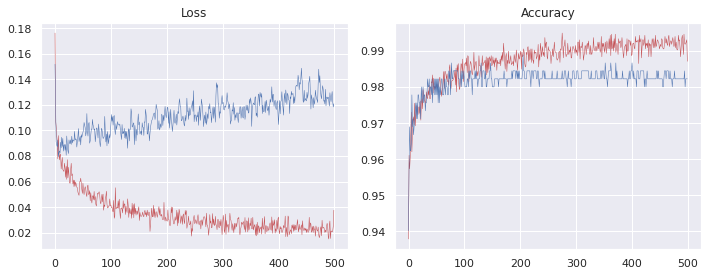

In [19]:
plot(history.history)

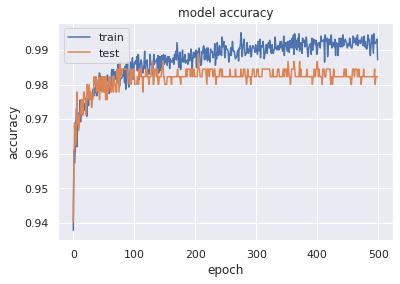

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

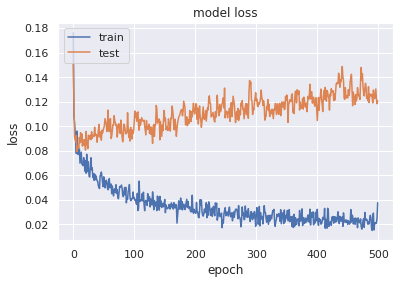

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
%%time
model.predict(x_train)

2022-04-20 11:06:54.094040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 626196480 exceeds 10% of free system memory.


CPU times: user 7.32 s, sys: 1.28 s, total: 8.6 s
Wall time: 9.93 s


array([[1.0000000e+00, 1.4805848e-11],
       [2.5738569e-03, 9.9742609e-01],
       [1.0000000e+00, 2.0150275e-10],
       ...,
       [1.0000000e+00, 2.8469736e-16],
       [1.0000000e+00, 7.9745238e-15],
       [1.0000000e+00, 3.4234265e-12]], dtype=float32)

In [23]:
%%time
y_pred = model.predict(x_test)

CPU times: user 1.31 s, sys: 263 ms, total: 1.57 s
Wall time: 1.47 s


In [24]:
Y_pred = np.argmax(y_pred, axis=1)

In [25]:
Y_test = np.argmax(y_test, axis=1)

In [26]:
Y_test  

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [27]:
Y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [28]:
%%time
result = model.predict(x_test[[0]])

CPU times: user 273 ms, sys: 3.91 ms, total: 276 ms
Wall time: 283 ms


In [29]:
cm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[682   2]
 [  6 225]]
Accuracy :  0.9912568306010929
Sensitivity :  0.9970760233918129
Specificity :  0.974025974025974


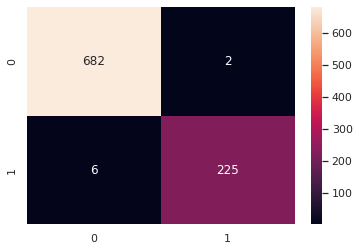

In [30]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

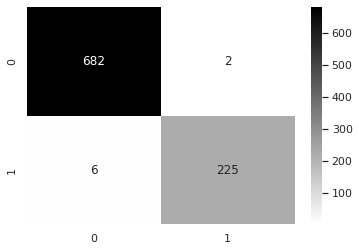

In [31]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="binary",annot=True,fmt="d")

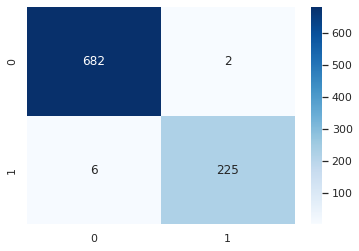

In [32]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="Blues", annot=True,fmt="d")

In [33]:
print(classification_report(Y_test, Y_pred, target_names = ['NORMAL', 'COVID']))

              precision    recall  f1-score   support

      NORMAL       0.99      1.00      0.99       684
       COVID       0.99      0.97      0.98       231

    accuracy                           0.99       915
   macro avg       0.99      0.99      0.99       915
weighted avg       0.99      0.99      0.99       915



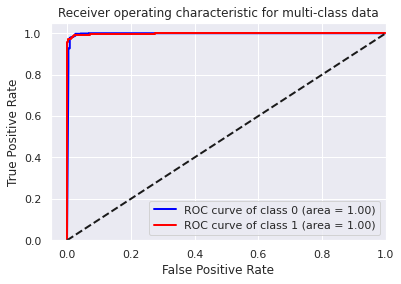

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [35]:
def display_training_curves(history, name, model_name, EPOCHS = 500):
    '''
    Plots the training process
    '''
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,15))
    fig.suptitle(model_name, size=20)
    
    # plot AUC
    ax1.plot(np.arange(EPOCHS),history.history['accuracy'],'-o',
             label='train',color='#ff7f0e')
    ax1.plot(np.arange(EPOCHS),history.history['val_accuracy'],'-o',
             label='val',color='#1f77b4')
    x = np.argmax(history.history['val_accuracy']); y = np.max(history.history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    ax1.scatter(x,y,s=200,color='#1f77b4')
    ax1.text(x-0.03*xdist,y-0.05*ydist,'max accuracy\n%.2f'%y,size=14)
    ax1.set_ylabel('Accuracy',size=14); ax1.set_xlabel('Epoch',size=14)
    ax1.set_title('Accuracy')
    ax1.set_xticks(list(range(EPOCHS)))
    ax1.set_xticklabels(list(range(1, EPOCHS+1)))
    ax1.legend(loc=2)

    #  plot loss
    ax2.plot(np.arange(EPOCHS),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    ax2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin(history.history['val_loss'] )
    y = np.min(history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    ax2.scatter(x,y,s=200,color='#d62728')
    ax2.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    ax2.set_ylabel('Loss',size=14); ax2.set_xlabel('Epoch',size=14)
    ax2.set_title('Loss')
    ax2.set_xticks(list(range(EPOCHS)))
    ax2.set_xticklabels(list(range(1, EPOCHS+1)))
    ax2.legend(loc=3)
    plt.savefig(name + '.png')
    plt.show() 

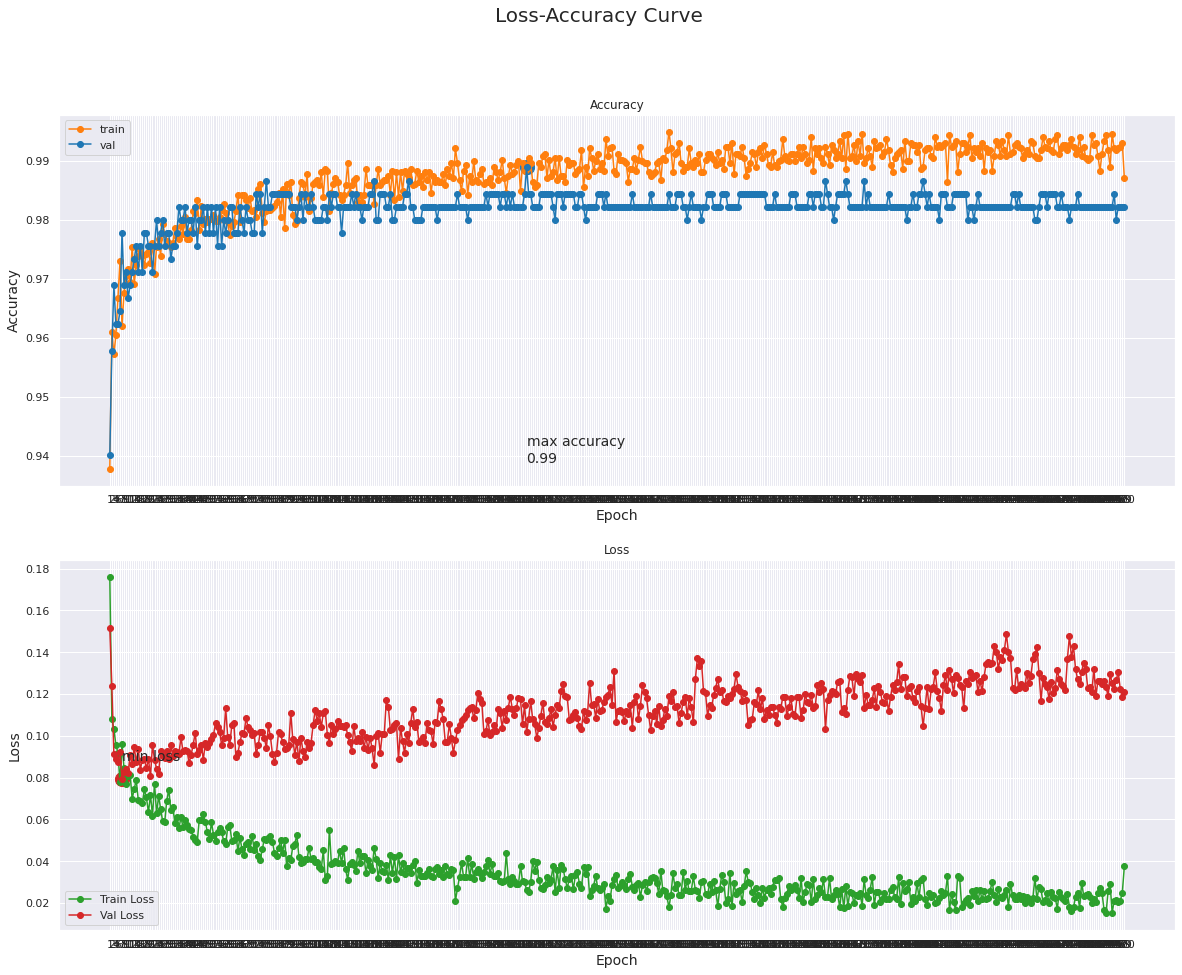

In [36]:
display_training_curves(history, 'name', 'Loss-Accuracy Curve')